In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import time

from numpy import *
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from datetime import datetime
from pickle import dump,load
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout, MaxPool1D, Reshape
from tensorflow.keras import Sequential

In [ ]:
#Import Data
url = 'https://github.com/nafisyanaa/Skripsi/blob/main/Data-LQ45.xlsx?raw=true'
data = pd.read_excel(url)
data

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,02/01/2019,984.35,983.58,986.57,980.21,"1,14B",0.0016
1,03/01/2019,990.88,983.09,990.88,981.16,"1,29B",0.0066
2,04/01/2019,1001.64,988.40,1001.64,985.94,"1,98B",0.0109
3,07/01/2019,1002.78,1012.40,1017.83,1002.78,"2,61B",0.0011
4,08/01/2019,997.42,1004.04,1008.43,994.01,"1,77B",-0.0053
...,...,...,...,...,...,...,...
975,26/12/2022,935.15,934.27,938.91,931.22,"2,37B",0.0009
976,27/12/2022,940.38,935.15,941.98,935.12,"3,70B",0.0056
977,28/12/2022,933.69,940.39,942.56,930.52,"2,94B",-0.0071
978,29/12/2022,939.87,933.69,940.06,926.80,"5,04B",0.0066


In [ ]:
data.dtypes

Tanggal        object
Terakhir      float64
Pembukaan     float64
Tertinggi     float64
Terendah      float64
Vol.           object
Perubahan%    float64
dtype: object

In [ ]:
#Get variable
y_value = pd.DataFrame(data.iloc[:,1])

In [ ]:
#Normalized the data
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler.fit(y_value)
y_scale_dataset = y_scaler.fit_transform(y_value)
dump(y_scaler, open('y_scaler.pkl', 'wb'))

In [ ]:
#Reshape the data to the format required for LSTM input
n_steps_in = 3
n_steps_out = 1

In [ ]:
#Get y and yc dataset
def get_y(y_data):
    y = list()
    yc = list()

    length = len(y_data)
    for i in range(0, length, 1):
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(y_value) == 1:
            y.append(y_value)
            yc.append(yc_value)

    return np.array(y), np.array(yc)

In [ ]:
#Get the train test predict index
def predict_index(dataset, y_train, n_steps_in, n_steps_out):

    train_predict_index = dataset.iloc[n_steps_in : y_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[y_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index

In [ ]:
#Split train and test dataset
def split_train_test(data):

    train_size = round(len(y) * 0.8)
    data_train = data[0:train_size]
    data_test = data[train_size:]

    return data_train, data_test

In [ ]:
#Get data and check shape
y, yc = get_y(y_scale_dataset)
y_train, y_test, = split_train_test(y)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(data, y_train, n_steps_in, n_steps_out)

print('y shape: ', y.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)

np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)
np.save("yc_train.npy", yc_train)
np.save("yc_test.npy", yc_test)
np.save('index_train.npy', index_train)
np.save('index_test.npy', index_test)

In [ ]:
#Make generator model
def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:

    model = Sequential()
    model.add(LSTM(units=1024, return_sequences=True, input_shape=(input_dim, feature_size), recurrent_dropout=0.3))
    model.add(LSTM(units=512, return_sequences=True, recurrent_dropout=0.3))
    model.add(LSTM(units=256, return_sequences=True, recurrent_dropout=0.3))
    model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.3))
    model.add(LSTM(units=64, return_sequences=True, recurrent_dropout=0.3))
    model.add(LSTM(units=output_dim, return_sequences=False))

    return model

In [ ]:
input_dim = yc_train.shape[1]
feature_size = yc_train.shape[2]
output_dim = y_train.shape[1]

model1 = make_generator_model(input_dim, output_dim, feature_size)
print(model1.summary())

In [ ]:
#Make discriminator model
def make_discriminator_model() -> tf.keras.models.Model:

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=1, padding='same'))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=1, padding='same'))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=True))
    cnn_net.add(Dense(220, use_bias=True))
    cnn_net.add(Dense(1, activation='sigmoid'))

    return cnn_net

In [ ]:
model2 = make_discriminator_model()
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 32)             128       
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 64)             10304     
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 128)            41088     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 220)               112860    
                                                                 
 dense_1 (Dense)             (None, 220)               48620     
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
#Train and evaluate GAN
class GAN:

    #Initialize and configure the essential elements of GAN model for training
    def __init__(self, generator, discriminator, opt, seed):
        self.seed = seed
        tf.random.set_seed(seed)
        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=opt["lr"], beta_1=0.9, beta_2=0.999)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=opt["lr"], beta_1=0.9, beta_2=0.999)
        self.batch_size = self.opt['bs']
        self.checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(
            generator_optimizer=self.generator_optimizer,
            discriminator_optimizer=self.discriminator_optimizer,
            generator=self.generator,
            discriminator=self.discriminator)

    #Calculate the discriminator loss
    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    #Calculate the generator loss
    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    #Perform a single iteration of GAN training process
    @tf.function
    def train_step(self, real_y, yc):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_y, training=True)
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            # Reshape for MLP
            # d_fake_input = tf.reshape(d_fake_input, [d_fake_input.shape[0], d_fake_input.shape[1]])
            # d_real_input = tf.reshape(d_real_input, [d_real_input.shape[0], d_real_input.shape[1]])

            real_output = self.discriminator(d_real_input, training=True)
            fake_output = self.discriminator(d_fake_input, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

    #Manage the entire training process for GAN model
    def train(self, real_y, yc, opt):
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(real_y, yc)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price.numpy())
            Real_price.append(real_price.numpy())

            #Save the model every epoch
            if (epoch + 1) % 1 == 0:
                tf.keras.models.save_model(generator, 'gen_model_3_1_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix + f'-{epoch}')
                print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())

            #For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        #Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return Predicted_price, Real_price, mean_absolute_percentage_error(Real_price, Predicted_price) * 100

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


epoch 1 d_loss 1.4295043 g_loss 0.73418856


epoch 2 d_loss 1.4081872 g_loss 0.7206416


epoch 3 d_loss 1.3881453 g_loss 0.7094022


epoch 4 d_loss 1.3691385 g_loss 0.7008237


epoch 5 d_loss 1.3509068 g_loss 0.6950678


epoch 6 d_loss 1.3332021 g_loss 0.6922005


epoch 7 d_loss 1.3158115 g_loss 0.69214636


epoch 8 d_loss 1.2985806 g_loss 0.69466335


epoch 9 d_loss 1.2814118 g_loss 0.69944435


epoch 10 d_loss 1.2642472 g_loss 0.7061997


epoch 11 d_loss 1.2470518 g_loss 0.71468043


epoch 12 d_loss 1.2298044 g_loss 0.7246739


epoch 13 d_loss 1.2124901 g_loss 0.73599136


epoch 14 d_loss 1.1950965 g_loss 0.7484595


epoch 15 d_loss 1.1776104 g_loss 0.7619193


epoch 16 d_loss 1.1600171 g_loss 0.77622133


epoch 17 d_loss 1.1423001 g_loss 0.7912243


epoch 18 d_loss 1.1244403 g_loss 0.8067919


epoch 19 d_loss 1.106417 g_loss 0.8227949


epoch 20 d_loss 1.0882077 g_loss 0.8391133


epoch 21 d_loss 1.0697907 g_loss 0.8556423


epoch 22 d_loss 1.0511453 g_loss 0.872296


epoch 23 d_loss 1.032254 g_loss 0.88901186


epoch 24 d_loss 1.0131022 g_loss 0.90575415


epoch 25 d_loss 0.9936805 g_loss 0.92251617


epoch 26 d_loss 0.9739839 g_loss 0.9393243


epoch 27 d_loss 0.95401216 g_loss 0.9562378


epoch 28 d_loss 0.93376935 g_loss 0.9733507


epoch 29 d_loss 0.91326314 g_loss 0.99078846


epoch 30 d_loss 0.89250386 g_loss 1.0087042


epoch 31 d_loss 0.8715044 g_loss 1.0272738


epoch 32 d_loss 0.85027957 g_loss 1.0466847


epoch 33 d_loss 0.8288459 g_loss 1.0671287


epoch 34 d_loss 0.80722237 g_loss 1.0887882


epoch 35 d_loss 0.7854304 g_loss 1.1118265


epoch 36 d_loss 0.76349485 g_loss 1.1363777


epoch 37 d_loss 0.74144447 g_loss 1.1625369


epoch 38 d_loss 0.7193115 g_loss 1.1903543


epoch 39 d_loss 0.6971315 g_loss 1.2198325


epoch 40 d_loss 0.6749434 g_loss 1.2509253


epoch 41 d_loss 0.6527876 g_loss 1.2835428


epoch 42 d_loss 0.6307061 g_loss 1.3175594


epoch 43 d_loss 0.6087413 g_loss 1.3528275


epoch 44 d_loss 0.5869361 g_loss 1.3891948


epoch 45 d_loss 0.56533384 g_loss 1.4265243


epoch 46 d_loss 0.54397786 g_loss 1.4647132


epoch 47 d_loss 0.5229118 g_loss 1.5037103


epoch 48 d_loss 0.50217927 g_loss 1.543526


epoch 49 d_loss 0.48182243 g_loss 1.5842329


epoch 50 d_loss 0.46188223 g_loss 1.6259569


epoch 51 d_loss 0.44239652 g_loss 1.6688579


epoch 52 d_loss 0.42340028 g_loss 1.7131062


epoch 53 d_loss 0.40492445 g_loss 1.7588495


epoch 54 d_loss 0.38699678 g_loss 1.8061894


epoch 55 d_loss 0.36964113 g_loss 1.8551557


epoch 56 d_loss 0.35287774 g_loss 1.9056962


epoch 57 d_loss 0.33672285 g_loss 1.9576772


epoch 58 d_loss 0.3211887 g_loss 2.0108948


epoch 59 d_loss 0.3062831 g_loss 2.0650995


epoch 60 d_loss 0.2920097 g_loss 2.1200266


epoch 61 d_loss 0.27836818 g_loss 2.175428


epoch 62 d_loss 0.2653544 g_loss 2.2311018


epoch 63 d_loss 0.25296116 g_loss 2.2869096


epoch 64 d_loss 0.24117848 g_loss 2.3427846


epoch 65 d_loss 0.22999366 g_loss 2.3987253


epoch 66 d_loss 0.21939176 g_loss 2.4547753


epoch 67 d_loss 0.20935571 g_loss 2.5110037


epoch 68 d_loss 0.19986682 g_loss 2.5674765


epoch 69 d_loss 0.190905 g_loss 2.624235


epoch 70 d_loss 0.18244922 g_loss 2.6812792


epoch 71 d_loss 0.17447782 g_loss 2.7385597


epoch 72 d_loss 0.16696894 g_loss 2.7959814


epoch 73 d_loss 0.15990052 g_loss 2.8534086


epoch 74 d_loss 0.15325062 g_loss 2.9106817


epoch 75 d_loss 0.14699763 g_loss 2.9676352


epoch 76 d_loss 0.14112027 g_loss 3.0241115


epoch 77 d_loss 0.13559788 g_loss 3.0799763


epoch 78 d_loss 0.13041043 g_loss 3.135129


epoch 79 d_loss 0.12553869 g_loss 3.1895041


epoch 80 d_loss 0.12096423 g_loss 3.2430727


epoch 81 d_loss 0.11666946 g_loss 3.2958362


epoch 82 d_loss 0.11263772 g_loss 3.3478177


epoch 83 d_loss 0.108853154 g_loss 3.3990545


epoch 84 d_loss 0.10530086 g_loss 3.4495842


epoch 85 d_loss 0.1019667 g_loss 3.4994407


epoch 86 d_loss 0.0988375 g_loss 3.5486434


epoch 87 d_loss 0.09590088 g_loss 3.5971963


epoch 88 d_loss 0.09314525 g_loss 3.645084


epoch 89 d_loss 0.0905599 g_loss 3.692273


epoch 90 d_loss 0.08813482 g_loss 3.7387187


epoch 91 d_loss 0.0858607 g_loss 3.784362


epoch 92 d_loss 0.08372902 g_loss 3.8291416


epoch 93 d_loss 0.081731826 g_loss 3.872994


epoch 94 d_loss 0.07986182 g_loss 3.915861


epoch 95 d_loss 0.07811232 g_loss 3.9576907


epoch 96 d_loss 0.076477185 g_loss 3.9984415


epoch 97 d_loss 0.0749508 g_loss 4.038081


epoch 98 d_loss 0.0735281 g_loss 4.0765867


epoch 99 d_loss 0.0722045 g_loss 4.1139426


epoch 100 d_loss 0.07097584 g_loss 4.1501393


epoch 101 d_loss 0.069838464 g_loss 4.1851683


epoch 102 d_loss 0.06878913 g_loss 4.219022


epoch 103 d_loss 0.06782503 g_loss 4.251686


epoch 104 d_loss 0.06694375 g_loss 4.283141


epoch 105 d_loss 0.066143304 g_loss 4.3133597


epoch 106 d_loss 0.06542212 g_loss 4.3423033


epoch 107 d_loss 0.064779 g_loss 4.369924


epoch 108 d_loss 0.06421317 g_loss 4.396167


epoch 109 d_loss 0.06372429 g_loss 4.420964


epoch 110 d_loss 0.06331238 g_loss 4.4442453


epoch 111 d_loss 0.06297797 g_loss 4.465933


epoch 112 d_loss 0.06272197 g_loss 4.4859467


epoch 113 d_loss 0.06254576 g_loss 4.5042067


epoch 114 d_loss 0.062451236 g_loss 4.5206337


epoch 115 d_loss 0.062440783 g_loss 4.5351505


epoch 116 d_loss 0.062517315 g_loss 4.547685


epoch 117 d_loss 0.06268432 g_loss 4.5581703


epoch 118 d_loss 0.062945925 g_loss 4.566546


epoch 119 d_loss 0.06330692 g_loss 4.5727572


epoch 120 d_loss 0.0637728 g_loss 4.5767584


epoch 121 d_loss 0.0643498 g_loss 4.5785117


epoch 122 d_loss 0.065045014 g_loss 4.5779905


epoch 123 d_loss 0.065866426 g_loss 4.575177


epoch 124 d_loss 0.06682295 g_loss 4.570071


epoch 125 d_loss 0.067924544 g_loss 4.5626884


epoch 126 d_loss 0.06918221 g_loss 4.5530624


epoch 127 d_loss 0.070608124 g_loss 4.541251


epoch 128 d_loss 0.07221562 g_loss 4.5273404


epoch 129 d_loss 0.07401928 g_loss 4.511442


epoch 130 d_loss 0.076034985 g_loss 4.4937


epoch 131 d_loss 0.07827981 g_loss 4.4742904


epoch 132 d_loss 0.08077207 g_loss 4.4534225


epoch 133 d_loss 0.083531216 g_loss 4.4313335


epoch 134 d_loss 0.08657767 g_loss 4.4082847


epoch 135 d_loss 0.08993267 g_loss 4.384551


epoch 136 d_loss 0.09361797 g_loss 4.3604107


epoch 137 d_loss 0.097655565 g_loss 4.3361235


epoch 138 d_loss 0.10206741 g_loss 4.311914


epoch 139 d_loss 0.10687496 g_loss 4.2879534


epoch 140 d_loss 0.11209896 g_loss 4.264337


epoch 141 d_loss 0.11775901 g_loss 4.2410808


epoch 142 d_loss 0.123873435 g_loss 4.218108


epoch 143 d_loss 0.1304593 g_loss 4.195267


epoch 144 d_loss 0.13753238 g_loss 4.1723514


epoch 145 d_loss 0.14510748 g_loss 4.1491413


epoch 146 d_loss 0.15319845 g_loss 4.1254416


epoch 147 d_loss 0.16181889 g_loss 4.1011057


epoch 148 d_loss 0.17098248 g_loss 4.0760508


epoch 149 d_loss 0.18070367 g_loss 4.050235


epoch 150 d_loss 0.19099864 g_loss 4.023629


epoch 151 d_loss 0.20188615 g_loss 3.9961631


epoch 152 d_loss 0.21338823 g_loss 3.9676793


epoch 153 d_loss 0.22553128 g_loss 3.9379096


epoch 154 d_loss 0.23834668 g_loss 3.906491


epoch 155 d_loss 0.25187093 g_loss 3.8730228


epoch 156 d_loss 0.2661458 g_loss 3.837149


epoch 157 d_loss 0.28121796 g_loss 3.7986448


epoch 158 d_loss 0.29713854 g_loss 3.7574642


epoch 159 d_loss 0.31396222 g_loss 3.7137134


epoch 160 d_loss 0.3317464 g_loss 3.6675644


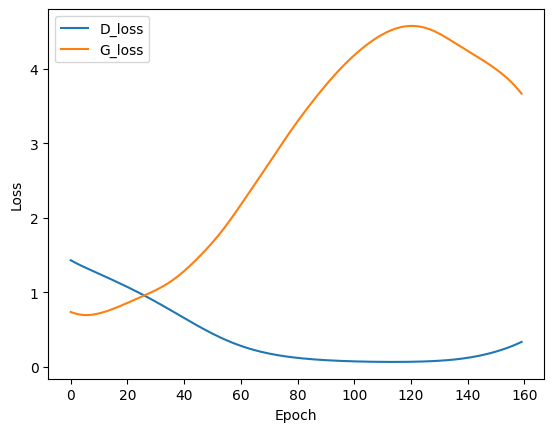

In [ ]:
#Orchestrates the entire training and evaluation process of the GAN model

if __name__ == '__main__':
    input_dim = yc_train.shape[1]
    feature_size = yc_train.shape[2]
    output_dim = y_train.shape[1]

    ## For Bayesian
    opt = {"lr": 0.00007,
    "bs": 128,
    "epoch": 160}

    generator = make_generator_model(yc_train.shape[1], output_dim, yc_train.shape[2])
    discriminator = make_discriminator_model()
    gan = GAN(generator, discriminator, opt, seed=42)
    Predicted_price, Real_price, MAPE = gan.train(y_train, yc_train, opt)

In [ ]:
#Save the predicted indices to files
np.save("train_predict_index.npy", index_train)
np.save("test_predict_index.npy", index_test)

In [ ]:
#Print predicted price
print("----- predicted price -----", Predicted_price)

In [ ]:
#Rescale back the real dataset
rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

----- rescaled predicted price ----- [[768.7344 ]
 [768.23334]
 [768.1721 ]
 [769.36633]
 [769.7029 ]
 [769.1792 ]
 [770.2425 ]
 [770.4483 ]
 [770.74255]
 [771.25134]
 [771.1085 ]
 [771.2837 ]
 [770.5249 ]
 [770.5846 ]
 [770.82043]
 [770.2282 ]
 [769.9022 ]
 [770.621  ]
 [771.9694 ]
 [772.2016 ]
 [770.66626]
 [771.68134]
 [771.4564 ]
 [771.0057 ]
 [770.3732 ]
 [769.2922 ]
 [768.8644 ]
 [768.54724]
 [768.00226]
 [770.1087 ]
 [769.7601 ]
 [770.24524]
 [770.7009 ]
 [769.8977 ]
 [770.3089 ]
 [770.74347]
 [770.4643 ]
 [769.0419 ]
 [770.1411 ]
 [770.1115 ]
 [769.1975 ]
 [769.33704]
 [768.00323]
 [768.0448 ]
 [767.9124 ]
 [768.10614]
 [768.8644 ]
 [769.838  ]
 [770.74786]
 [770.24615]
 [770.3402 ]
 [770.71686]
 [770.83276]
 [768.85046]
 [770.0881 ]
 [769.4377 ]
 [770.21655]
 [770.2183 ]
 [769.96185]
 [770.2793 ]
 [770.83545]
 [770.4188 ]
 [769.8815 ]
 [770.6938 ]
 [770.6734 ]
 [769.2141 ]
 [769.26   ]
 [769.69836]
 [770.65656]
 [771.2014 ]
 [769.63293]
 [770.5285 ]
 [770.31604]
 [768.93933]
 

In [ ]:
#Prepare and organize the predicted and real price data after training GAN model
train_predict_index = np.load("train_predict_index.npy", allow_pickle=True)
test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

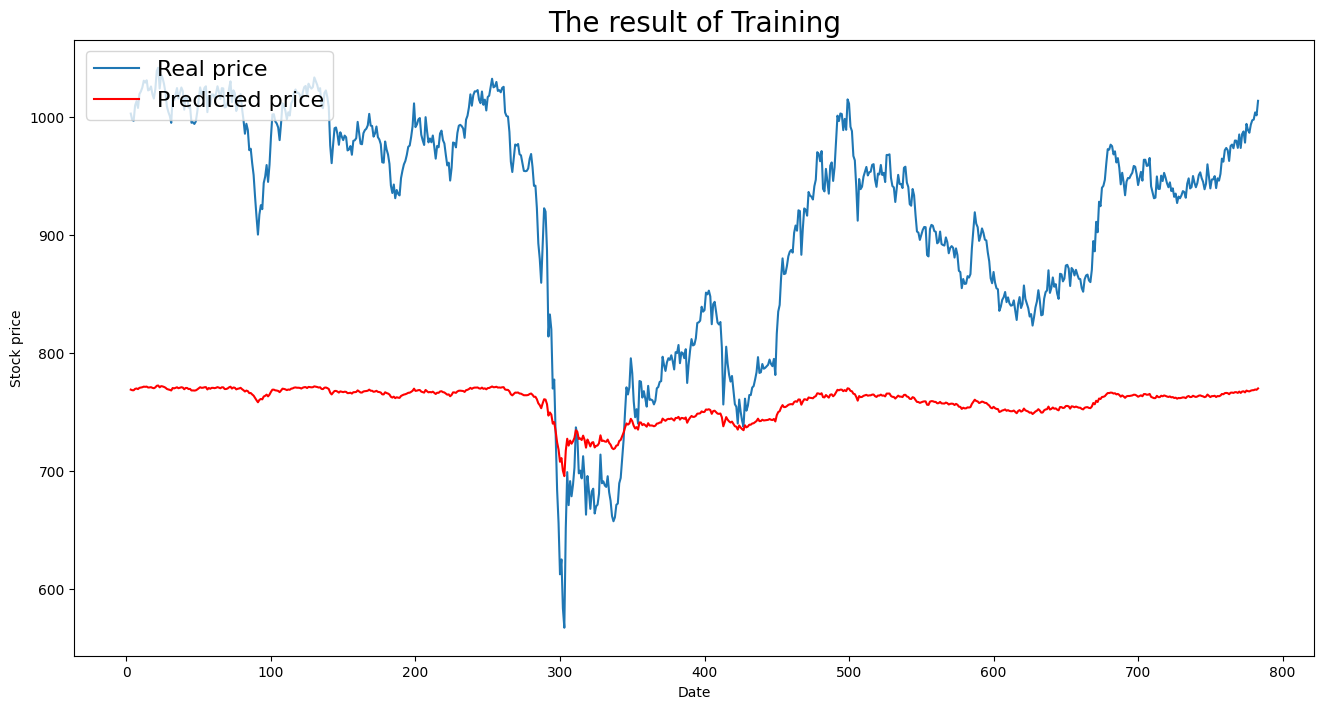

In [ ]:
#Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training", fontsize=20)
plt.show()

In [ ]:
#Calculate MAPE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]

MAPE = mean_absolute_percentage_error(predicted, real) * 100

print('-- Train MAPE -- ', MAPE)

-- Train MAPE --  20.934064918657306


In [ ]:
#Save the model
generator.save('gen_GRU_model_89.h5')

In [ ]:
#Predict the testing data
def get_test_plot(yc_test, y_test):

    #Set output steps
    output_dim = y_test.shape[1]

    #Get predicted data
    G_model = tf.keras.models.load_model('gen_GRU_model_89.h5')
    y_predicted = G_model(yc_test)
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    rescaled_Real_price = y_scaler.inverse_transform(y_test)
    rescaled_Predicted_price = y_scaler.inverse_transform(y_predicted)

    #Predicted price
    predict_result = pd.DataFrame()
    for i in range(y_predicted.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    #Real price
    real_price = pd.DataFrame()
    for i in range(y_test.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')

    #Calculate MAPE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    MAPE = mean_absolute_percentage_error(predicted, real) * 100
    print('-- MAPE -- ', MAPE)

    return predict_result, MAPE

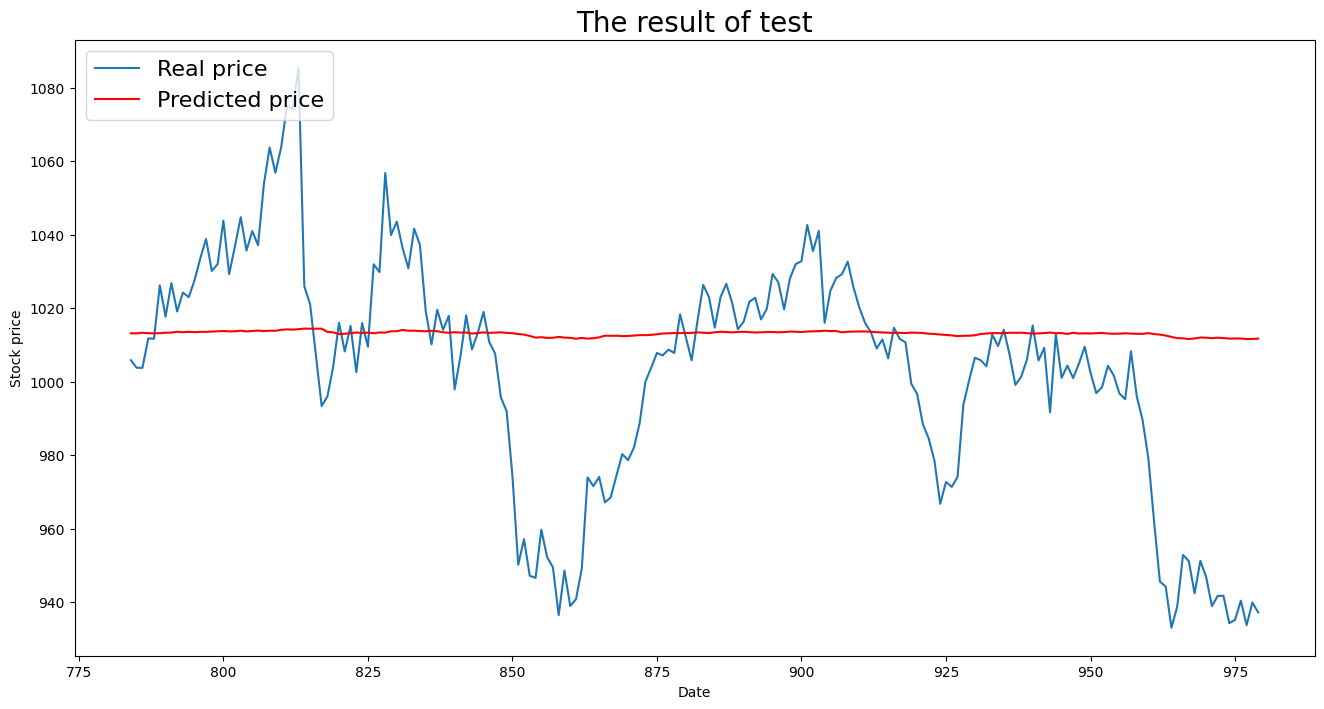

-- MAPE --  2.3740642972485166


<Figure size 640x480 with 0 Axes>

In [ ]:
#Plot the predicted result and calculate MAPE
test_predicted, test_MAPE = get_test_plot(yc_test, y_test)
test_predicted.to_csv("test_predicted.csv")